<a href="https://colab.research.google.com/github/jainkhere/cs480student/blob/main/Training_unet_on_lucchi%2B%2B_data_Kunal_Jain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Train a U-Net classifer on lucchi++ dataset

In [1]:
# load numpy and matplotlib
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# load the unet tensorflow code
!pip install git+https://github.com/jakeret/unet.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/jakeret/unet.git to /tmp/pip-req-build-79npe049
  Running command git clone -q https://github.com/jakeret/unet.git /tmp/pip-req-build-79npe049
  Created wheel for unet: filename=unet-0.0.post0.dev81+gf557a51-py2.py3-none-any.whl size=25688 sha256=bdb912ceb3fb2c37e5eed903df89f3357727587ab54ced6b18482ce66f949602
  Stored in directory: /tmp/pip-ephem-wheel-cache-4fd92p75/wheels/22/00/93/ce57529ed355f160088cbb6ce086e55168770913b40cf624ba
Successfully built unet


In [3]:
# .. and use it!
# Note: There are a ton of U-Net implementations but this one is easier to use!
import unet

In [4]:
!pip install mahotas

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.7 MB 9.8 MB/s 


In [5]:
import mahotas as mh
import os

In [6]:
import matplotlib.pyplot as plt

**Task 1**: Study the unet circle example and learn about mitochondria! [15 Points]

**Task 2**: Setup a datagenerator for mitochondria images! [45 Points]

In [7]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [8]:
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/CS480/lucchi_pp.zip', 'r') as zip_ref:
    zip_ref.extractall('.')

In [9]:
TEST_IN_DIR = "lucchi_pp/Lucchi++/Test_In/"
TEST_OUT_DIR = "lucchi_pp/Lucchi++/Test_Out/"
TRAIN_IN_DIR = "lucchi_pp/Lucchi++/Train_In/"
TRAIN_OUT_DIR = "lucchi_pp/Lucchi++/Train_Out/"

In [34]:
train_in_files = os.listdir(TRAIN_IN_DIR)
train_out_files = os.listdir(TRAIN_OUT_DIR)
test_in_files = os.listdir(TEST_IN_DIR)
test_out_files = os.listdir(TEST_OUT_DIR)

In [14]:
IMAGE_SIZE = (256, 256)

In [15]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_datasets.core import DatasetInfo
from typing import Tuple, List

In [16]:
train_in_images = np.zeros((len(train_in_files), 256, 256), dtype=np.float32)

for i in range(len(train_in_files)):
  loaded_image = mh.imread( TRAIN_IN_DIR + train_in_files[i], as_grey=True )

  loaded_image = mh.imresize( loaded_image, (256, 256) )
  img_shape = loaded_image.shape
  
  train_in_images[ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [17]:
train_out_images = np.zeros( (len(train_out_files), 256, 256), dtype=np.float32)

for i in range(len(train_out_files)):
  loaded_image = mh.imread( TRAIN_OUT_DIR + train_out_files[i], as_grey=True )
  
  loaded_image = mh.imresize( loaded_image, (256, 256) )
  img_shape = loaded_image.shape

  train_out_images[ i, 0:img_shape[0], 0:img_shape[1] ] = loaded_image

In [46]:
train_in_images.shape

(165, 256, 256)

In [47]:
train_out_images.shape

(165, 256, 256)

In [51]:
def load_data(count:int, splits:Tuple[float]=(0.7, 0.2, 0.1)) -> List[tf.data.Dataset]:
    return [tf.data.Dataset.from_tensor_slices(_build_samples(int(split * count)))
            for split in splits]

def _build_samples(sample_count:int, **kwargs) -> Tuple[np.array, np.array]:
  images = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 1))
  labels = np.empty((sample_count, IMAGE_SIZE[0], IMAGE_SIZE[1], 2))

  loadedimages = train_in_images.copy()
  loadedmasks = train_out_images.copy()

  for i in range(sample_count):
    image, mask = loadedimages[i], loadedmasks[i]

    image = image.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1)).astype(np.float)
    mask = mask.reshape((IMAGE_SIZE[0], IMAGE_SIZE[1], 1))

    #
    # TODO: Normalize the image to 0..1
    #

    image = tf.cast(image, tf.float32) / 255.0
    mask -= 1

    #
    # TODO: Use Tensorflow to flip the image horizontally
    #
    if tf.random.uniform(()) > 0.5:
      #
      # TODO: YOUR CODE
      #
      image = tf.image.flip_left_right(image)
      mask = tf.image.flip_left_right(mask)

    #
    # TODO: Use Tensorflow to flip the image vertically
    #
    if tf.random.uniform(()) > 0.5:
      #
      # TODO: YOUR CODE
      #
      image = tf.image.flip_up_down(image)
      mask = tf.image.flip_up_down(mask)

    #
    # TODO: Use Tensorflow to rotate the image 90 degrees
    #
    if tf.random.uniform(()) > 0.5:
      #
      # TODO: YOUR CODE
      #
      image = tf.image.rot90(image)
      mask = tf.image.rot90(mask)


    # augmentation done, let's store the image
    images[i] = image

    # here we split the mask to background and foreground
    fg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
    fg[mask == 255] = 1
    bg = np.zeros((IMAGE_SIZE[0], IMAGE_SIZE[1], 1), dtype=np.bool)
    bg[mask == 0] = 1

    labels[i, :, :, 0] = bg[:,:,0]
    labels[i, :, :, 1] = fg[:,:,0]

  return images, labels

train, val, test = load_data(165, splits=(0.7, 0.2, 0.1))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  app.launch_new_instance()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:62: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:64: DeprecationWarning: `np.bool` is a

In [52]:
channels = 1
classes = 2

LEARNING_RATE = 1e-3

unet_model = unet.build_model(channels=channels,
                              num_classes=classes,
                              layer_depth=5,
                              filters_root=64,
                              padding="same")

unet.finalize_model(unet_model, learning_rate=LEARNING_RATE)

In [53]:
trainer = unet.Trainer(checkpoint_callback=False,
                       learning_rate_scheduler=unet.SchedulerType.WARMUP_LINEAR_DECAY,
                       warmup_proportion=0.1,
                       learning_rate=LEARNING_RATE)

In [54]:
trainer.fit(unet_model,
            #
            # TODO: YOUR CODE
            #
            #
            train,
            val,
            epochs=50,
            batch_size=10
            )

1/1 [==============================] - 0s 418ms/step
Epoch 1/50
12/12 [==============================] - 12s 792ms/step - loss: 0.0000e+00 - categorical_crossentropy: 0.0000e+00 - categorical_accuracy: 0.6875 - mean_iou: 0.0000e+00 - dice_coefficient: 1.5259e-05 - auc_3: 0.0000e+00 - learning_rate: 9.8718e-05 - val_loss: 0.0000e+00 - val_categorical_crossentropy: 0.0000e+00 - val_categorical_accuracy: 1.0000 - val_mean_iou: 0.0000e+00 - val_dice_coefficient: 1.5259e-05 - val_auc_3: 0.0000e+00
Epoch 2/50
12/12 [==============================] - 8s 713ms/step - loss: 0.0000e+00 - categorical_crossentropy: 0.0000e+00 - categorical_accuracy: 0.9426 - mean_iou: 0.0000e+00 - dice_coefficient: 1.5259e-05 - auc_3: 0.0000e+00 - learning_rate: 2.9872e-04 - val_loss: 0.0000e+00 - val_categorical_crossentropy: 0.0000e+00 - val_categorical_accuracy: 1.0000 - val_mean_iou: 0.0000e+00 - val_dice_coefficient: 1.5259e-05 - val_auc_3: 0.0000e+00
Epoch 3/50
12/12 [==============================] - 10s 80

1/1 [==============================] - 0s 18ms/step


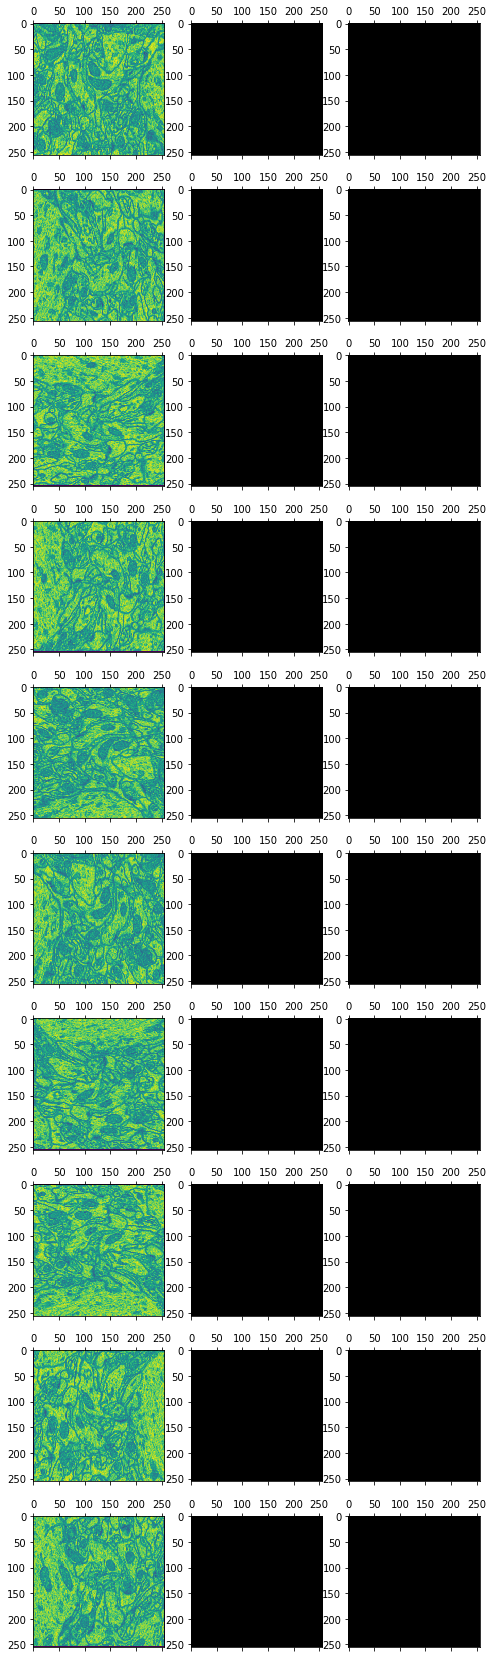

In [55]:
rows = 10
fig, axs = plt.subplots(rows, 3, figsize=(8, 30))
for ax, (image, label) in zip(axs, test.take(rows).batch(1)):
  
  prediction = unet_model.predict(image)
  ax[0].matshow(image[0, :, :, 0])
  ax[1].matshow(label[0, :, :, 1], cmap="gray")
  ax[2].matshow(prediction[0].argmax(axis=-1), cmap="gray")